In [11]:
import re
import requests
import json
from bs4 import BeautifulSoup 
import random
import numpy as np
from IPython.core.display import HTML
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import locale
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

In [12]:
CIKNumber = '0000037996' #'0001341439,0001326801,0000104169, 0001018724, 0000027419, 0000037996, 0001364742'
filingType = "10-K"
baseURL = "https://www.sec.gov"

filingParameters = {'action':'getcompany',
                                  'CIK':CIKNumber,
                                  'type':filingType,
                                  'dateb':'',
                                  'owner':'exclude',
                                  'start':'',
                                  'output':'',
                                  'count':'100'}

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36'}

apiResponse = requests.get(f"https://data.sec.gov/api/xbrl/companyfacts/CIK{CIKNumber}.json", headers=header)

if apiResponse.ok:
    apiData = json.loads(apiResponse.content)
    print(f"Compancy Name: {apiData['entityName']}")
else:
    print(apiResponse.status_code)
    print(apiResponse.reason)
    
# request the url, and then parse the response.
companyResponse = requests.get(url=r"https://www.sec.gov/cgi-bin/browse-edgar", params=filingParameters, headers=header)

#print(response.content)
companyParser = BeautifulSoup(companyResponse.content, 'html.parser')
documentLink = companyParser.find("a", {"id":"documentsbutton"})
print(baseURL + documentLink["href"])

documentResponse = requests.get(baseURL + documentLink["href"], headers=header)
#print(documentResponse.content)

documentParser = BeautifulSoup(documentResponse.content, 'html.parser')
xmlTable = documentParser.find("table", {"summary":"Data Files"})
xmlTableData = xmlTable.find_all("td", {"scope":"row"})

xmlSchemaData = None

i=0

while i < len(xmlTableData):
    if xmlTableData[i].getText() == "XBRL TAXONOMY EXTENSION CALCULATION LINKBASE DOCUMENT":
        xmlSchemaData = xmlTableData[i+1].find("a")
        break
    
    i+=1
    
print(baseURL + xmlSchemaData["href"])

schemaReportResponse = requests.get(baseURL + xmlSchemaData["href"], headers=header)
#print(schemaReportResponse.content)

schemaReportParser = BeautifulSoup(schemaReportResponse.content, features="xml")
financialStatements = schemaReportParser.find_all("link:calculationLink", {"xlink:type":"extended"})

data = {"statement": []}

for statement in financialStatements:
    statementName = statement["xlink:role"].split("role/")[1]
    
    if statementName.startswith("Role_"):
        try:
            statementName = statementName.split("Role_")[1]
        except:
            continue

    statementDictionary = {"name":statementName, "concept": []}
    
    concepts = statement.find_all("link:calculationArc", {"xlink:type":"arc"})
    
    for concept in concepts:
        try:
            sectionName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:from"]).group(1)
            conceptName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:to"]).group(1)
            conceptDictionary = {"section": sectionName, \
                                 "name": conceptName, \
                                 "data": apiData["facts"]["us-gaap"][conceptName]}
        except:
            try:
                conceptDictionary = {"section":concept["xlink:from"], "name":concept["xlink:to"], \
                                     "data":apiData["facts"]["us-gaap"][concept["xlink:to"].split("us-gaap_")[1]]}
            except:
                continue
        finally:
            statementDictionary["concept"].append(conceptDictionary)
    
    data["statement"].append(statementDictionary)

# Print Struncture
    # print()
    # print("-------------------")
    # print(f'Statement Name: {statementName}')
    # for concept in concepts:
    #     try:
    #         sectionName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:from"]).group(1)
    #         conceptName = re.search(r"\w*us-gaap_([a-zA-Z0-9]*)_?.*$",concept["xlink:to"]).group(1)
    #         print(f'Section Name: {sectionName}')
    #         print(f'Concept Name: {conceptName}')
    #     except:
    #         continue

# print(data)

# Compancy Name: Oracle Corporation
# https://www.sec.gov/Archives/edgar/data/1341439/000095017023028914/0000950170-23-028914-index.htm
# https://www.sec.gov/Archives/edgar/data/1341439/000095017023028914/orcl-20230531_cal.xml
# FS: us-gaap_LiabilitiesAndStockholdersEquity
# Concept: us-gaap_StockholdersEquityIncludingPortionAttributableToNoncontrollingInterest

# Compancy Name: Meta Platforms, Inc.
# https://www.sec.gov/Archives/edgar/data/1326801/000132680123000013/0001326801-23-000013-index.htm
# https://www.sec.gov/Archives/edgar/data/1326801/000132680123000013/meta-20221231_cal.xml
# FS: loc_us-gaap_StockholdersEquity_d91831d7-4445-486b-8720-eef0838228c6
# Concept: loc_us-gaap_CommonStockValue_4bbe192a-2f70-4746-b214-ffcde0a70cb6

# Compancy Name: WALMART INC.
# https://www.sec.gov/Archives/edgar/data/104169/000010416923000020/0000104169-23-000020-index.htm
# https://www.sec.gov/Archives/edgar/data/104169/000010416923000020/wmt-20230131_cal.xml
# FS: loc_us-gaap_ProfitLoss_9f64ec3f-f5d4-4eff-9cd4-01674db524d4
# Concept: loc_us-gaap_IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest_20eda8ed-37d3-4ba1-8c87-739b2906f134

# Compancy Name: AMAZON.COM, INC.
# https://www.sec.gov/Archives/edgar/data/1018724/000101872423000004/0001018724-23-000004-index.htm
# https://www.sec.gov/Archives/edgar/data/1018724/000101872423000004/amzn-20221231_cal.xml
# FS: loc_us-gaap_NetCashProvidedByUsedInFinancingActivities_3816386b-0fc0-412e-9a41-01122928647f
# Concept: loc_us-gaap_ProceedsFromIssuanceOfLongTermDebt_a8a81f73-b463-4514-aa94-f82335360f28

# Compancy Name: TARGET CORPORATION
# https://www.sec.gov/Archives/edgar/data/27419/000002741923000015/0000027419-23-000015-index.htm
# https://www.sec.gov/Archives/edgar/data/27419/000002741923000015/tgt-20230128_cal.xml
# FS: loc_us-gaap_OperatingIncomeLoss_5e38cd4d-4123-447e-8077-563b5f255431
# Concept: loc_us-gaap_CostOfGoodsAndServicesSold_db875d1d-3248-4cbf-a03d-f87d377120bb

# def extractConcept(val):
    

Compancy Name: Ford Motor Co
https://www.sec.gov/Archives/edgar/data/37996/000003799623000012/0000037996-23-000012-index.htm
https://www.sec.gov/Archives/edgar/data/37996/000003799623000012/f-20221231_cal.xml


In [13]:
for fs in data["statement"]:
    print(fs["name"])
    print(f'Count of Concepts: {len(fs["concept"])}')

CONSOLIDATEDSTATEMENTOFCASHFLOWS
Count of Concepts: 38
CONSOLIDATEDINCOMESTATEMENT
Count of Concepts: 13
CONSOLIDATEDSTATEMENTOFCOMPREHENSIVEINCOME
Count of Concepts: 8
CONSOLIDATEDBALANCESHEET
Count of Concepts: 30
IncomeTaxesDetails
Count of Concepts: 32
CapitalStockandEarningsPerShareDetails
Count of Concepts: 2
CashCashEquivalentsandMarketableSecuritiesAvailableforSaleSecuritiesDetails
Count of Concepts: 10
FordCreditFinanceReceivablesFordCreditFinanceLeasesDetails
Count of Concepts: 6
InventoriesDetails
Count of Concepts: 2
NetInvestmentinOperatingLeasesDetails
Count of Concepts: 2
NetInvestmentinOperatingLeasesOperatingLeaseAmountsContractuallyDueDetails
Count of Concepts: 5
NetPropertyDetails
Count of Concepts: 2
OtherLiabilitiesandDeferredRevenueDetails
Count of Concepts: 15
RetirementBenefitsExpenseDetails
Count of Concepts: 7
RetirementBenefitsStatusDetails
Count of Concepts: 4
LeaseCommitmentsLeaseCommitmentsRightofUseAssetsandLiabilitiesDetails
Count of Concepts: 6
LeaseCom

In [14]:
financialStatementIndex = 0
print(data["statement"][financialStatementIndex]["name"])
print(f'Count of Concepts: {len(data["statement"][financialStatementIndex]["concept"])}')

CONSOLIDATEDSTATEMENTOFCASHFLOWS
Count of Concepts: 38


In [15]:
features = []
revFound = False
revIndex = 0
for index, con in enumerate(data["statement"][financialStatementIndex]["concept"]):
    print(f'Section: {con["section"]}')
    print(f'Name: {con["name"]}')
    print(f'data label: {con["data"]["label"]}')
    print(f'data Description: {con["data"]["description"]}')
    print()
    features.append(con)
    revFound = True if con["name"] == "Revenues" else False
    revIndex = index if con["name"] == "Revenues" else revIndex
# data["statement"][3]["concept"]
if not revFound:
    # Check existence of Revenue Key. If not available delete
    if "Revenues" in list(apiData["facts"]["us-gaap"]):
        features.append({"name":"Revenues","Name":"Revenues","Description":"Revenues","data":apiData["facts"]["us-gaap"]["Revenues"]})
        revIndex = len(features)-1
    else:
        raise Exception("No Revenue Data found")

Section: NetCashProvidedByUsedInOperatingActivities
Name: OtherOperatingActivitiesCashFlowStatement
data label: Other Operating Activities, Cash Flow Statement
data Description: Other cash or noncash adjustments to reconcile net income to cash provided by (used in) operating activities that are not separately disclosed in the statement of cash flows (for example, cash received or cash paid during the current period for miscellaneous operating activities, net change during the reporting period in other assets or other liabilities).

Section: NetCashProvidedByUsedInOperatingActivities
Name: DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown
data label: Disposal Group, Not Discontinued Operation, Loss (Gain) on Write-down
data Description: Amount, before tax, of (gain) loss recognized for the (reversal of write-down) write-down to fair value, less cost to sell, of a disposal group. Excludes discontinued operations.

Section: NetCashProvidedByUsedInOperatingActivities
Name: GainLossO

In [16]:
financialData = {}
for feature in features:
    print(feature["name"])
    unit = "USD"
    if not unit in list(feature["data"]["units"]):
        if len(list(feature["data"]["units"])) == 1:
            unit = list(feature["data"]["units"])[0]
        else:
            unit = "USD/shares"
        
    for element in feature["data"]["units"][unit]:
        if element["end"] in financialData:
            financialData[element["end"]][feature["name"]] = element["val"]
        else:
            financialData[element["end"]] = {f'{feature["name"]}': element["val"]} 
    print(f"{feature['name']} processed successfully")

# for year in financialData:
#     if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] and "StockholdersEquity" in financialData[year]:
#         financialData[year]["DebtToEquityRatio"] = (financialData[year]["LiabilitiesCurrent"] + financialData[year]["LiabilitiesNoncurrent"]) / financialData[year]["StockholdersEquity"]
        
#     if "LiabilitiesCurrent" in financialData[year] and "LiabilitiesNoncurrent" in financialData[year] and "AssetsCurrent" in financialData[year]:
#         financialData[year]["CurrentRatio"] = financialData[year]["LiabilitiesCurrent"] / financialData[year]["AssetsCurrent"]

OtherOperatingActivitiesCashFlowStatement
OtherOperatingActivitiesCashFlowStatement processed successfully
DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown
DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown processed successfully
GainLossOnDispositionOfAssets1
GainLossOnDispositionOfAssets1 processed successfully
RestructuringCharges
RestructuringCharges processed successfully
Depreciation
Depreciation processed successfully
PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash
PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash processed successfully
IncreaseDecreaseInInventories
IncreaseDecreaseInInventories processed successfully
GainsLossesOnExtinguishmentOfDebt
GainsLossesOnExtinguishmentOfDebt processed successfully
ShareBasedCompensation
ShareBasedCompensation processed successfully
AdjustmentForAmortization
AdjustmentForAmortization processed successfully
IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions
IncomeLossF

In [17]:
len(financialData)

63

In [18]:
print(financialData[list(financialData)[0]])

{'OtherOperatingActivitiesCashFlowStatement': -36000000, 'DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown': 0, 'GainLossOnDispositionOfAssets1': 44000000, 'Depreciation': 6930000000, 'PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash': -387000000, 'GainsLossesOnExtinguishmentOfDebt': 0, 'ShareBasedCompensation': 199000000, 'AdjustmentForAmortization': -626000000, 'IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions': -15000000, 'IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities': 6786000000, 'ProvisionForLoanLeaseAndOtherLosses': 125000000, 'IncreaseDecreaseInFinanceReceivables': -746000000, 'ProfitLoss': 993000000, 'ProceedsFromCollectionOfFinanceReceivables': 38418000000, 'PaymentsToAcquireMarketableSecurities': 14547000000, 'PaymentsToAcquireProductiveAssets': 5669000000, 'PaymentsForProceedsFromOtherInvestingActivities': 201000000, 'PaymentsToAcquireLoansAndLeasesHeldForInvestment': 48227000000, 'PaymentsForProceedsFromDerivati

In [19]:
dfData = []
for row in financialData:
    record = financialData[row]
    record["Quarter"]= row
    record["Revenue Increased"] = random.choice([0,1])
    dfData.append(record)
    
financialDataDF = pd.DataFrame(dfData)

In [20]:
financialDataDF.head(10)

,OtherOperatingActivitiesCashFlowStatement,DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown,GainLossOnDispositionOfAssets1,Depreciation,PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash,GainsLossesOnExtinguishmentOfDebt,ShareBasedCompensation,AdjustmentForAmortization,IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions,IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities,...,GainLossOnInvestments,ProceedsFromDivestitureOfInterestInConsolidatedSubsidiaries,RestructuringCharges,IncreaseDecreaseInInventories,DeferredIncomeTaxesAndTaxCredits,IncreaseDecreaseInAccountsAndOtherReceivables,ForeignCurrencyTransactionGainLossUnrealized,PaymentsToAcquireEquityMethodInvestments,ProceedsFromOtherDebt,RepaymentsOfOtherDebt
0,-36000000.0,0.0,4.400000e+07,6.930000e+09,-3.870000e+08,0.0,199000000.0,-6.260000e+08,-15000000.0,6.786000e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,112000000.0,0.0,3.000000e+06,2.429000e+09,-1.800000e+07,NaN,85000000.0,-2.870000e+08,-17000000.0,2.944000e+09,...,67000000.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,186000000.0,0.0,2.000000e+06,4.988000e+09,1.230000e+08,-53000000.0,169000000.0,-5.870000e+08,-21000000.0,4.929000e+09,...,-187000000.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-44000000.0,799000000.0,4.600000e+07,7.310000e+09,4.010000e+08,-1000000.0,238000000.0,-8.910000e+08,-73000000.0,5.226000e+09,...,199000000.0,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-207000000.0,3000000.0,1.500000e+07,2.444000e+09,-1.780000e+08,NaN,38000000.0,-3.020000e+08,-118000000.0,1.940000e+08,...,-32000000.0,1.340000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,-165000000.0,18000000.0,3.480000e+09,4.802000e+09,-4.540000e+08,-1000000.0,107000000.0,-5.900000e+08,-169000000.0,-2.485000e+09,...,47000000.0,1.340000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-253000000.0,21000000.0,3.483000e+09,6.670000e+09,-4.540000e+08,0.0,170000000.0,-9.380000e+08,-132000000.0,3.858000e+09,...,297000000.0,1.340000e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,72000000.0,23000000.0,3.446000e+09,8.751000e+09,1.027000e+09,-1000000.0,199000000.0,-1.294000e+09,-130000000.0,6.809000e+09,...,315000000.0,1.340000e+09,1.159000e+09,-148000000.0,-269000000.0,63000000.0,420000000.0,4000000.0,6.590000e+10,6.051400e+10
8,-107000000.0,NaN,1.660000e+08,2.103000e+09,-3.180000e+08,NaN,41000000.0,-3.610000e+08,-68000000.0,1.930000e+08,...,899000000.0,7.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,-244000000.0,NaN,3.320000e+08,3.639000e+09,-8.080000e+08,NaN,183000000.0,-7.150000e+08,-52000000.0,-6.438000e+09,...,7000000.0,1.440000e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
financialDataDF.set_index("Quarter", inplace=True)
financialDataDF.fillna(0, inplace=True)
financialDataDF.shape

(63, 40)

In [22]:
financialDataDF.isnull().sum()

OtherOperatingActivitiesCashFlowStatement                                              0
DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown                               0
GainLossOnDispositionOfAssets1                                                         0
Depreciation                                                                           0
PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash                   0
GainsLossesOnExtinguishmentOfDebt                                                      0
ShareBasedCompensation                                                                 0
AdjustmentForAmortization                                                              0
IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions                     0
IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities                          0
ProvisionForLoanLeaseAndOtherLosses                                                    0
IncreaseDecreaseInFin

In [23]:
# Update Revenue Increased column based on data
Revenue_Index_no = financialDataDF.columns.get_loc("Revenues")
RI_Index_no = financialDataDF.columns.get_loc("Revenue Increased")

for i in range(len(financialDataDF)):
    if i == 0:
        financialDataDF.iloc[i, RI_Index_no] = 0
    else:
        financialDataDF.iloc[i, RI_Index_no] = 1 if financialDataDF.iloc[i, Revenue_Index_no] > financialDataDF.iloc[i-1, Revenue_Index_no] else 0
financialDataDF[["Revenues","Revenue Increased"]].head(10)

,Revenues,Revenue Increased
Quarter,,
2018-09-30,3.766600e+10,0
2019-03-31,4.034200e+10,1
2019-06-30,3.885300e+10,0
2019-09-30,3.699000e+10,0
2020-03-31,3.432000e+10,0
2020-06-30,1.937100e+10,0
2020-09-30,3.750100e+10,1
2020-12-31,3.595200e+10,0
2021-03-31,3.622800e+10,1


In [24]:
# Separator data in predictors(x) and labels(y)
predictors = financialDataDF.loc[:,financialDataDF.columns != "Revenue Increased"]
labels = financialDataDF.loc[:,"Revenue Increased"]
predictors.head(20)

,OtherOperatingActivitiesCashFlowStatement,DisposalGroupNotDiscontinuedOperationLossGainOnWriteDown,GainLossOnDispositionOfAssets1,Depreciation,PensionAndOtherPostretirementBenefitsExpenseReversalOfExpenseNoncash,GainsLossesOnExtinguishmentOfDebt,ShareBasedCompensation,AdjustmentForAmortization,IncomeLossFromEquityMethodInvestmentsNetOfDividendsOrDistributions,IncreaseDecreaseInAccountsPayableAndOtherOperatingLiabilities,...,GainLossOnInvestments,ProceedsFromDivestitureOfInterestInConsolidatedSubsidiaries,RestructuringCharges,IncreaseDecreaseInInventories,DeferredIncomeTaxesAndTaxCredits,IncreaseDecreaseInAccountsAndOtherReceivables,ForeignCurrencyTransactionGainLossUnrealized,PaymentsToAcquireEquityMethodInvestments,ProceedsFromOtherDebt,RepaymentsOfOtherDebt
Quarter,,,,,,,,,,,,,,,,,,,,,
2018-09-30,-36000000.0,0.0,4.400000e+07,6.930000e+09,-3.870000e+08,0.000000e+00,199000000.0,-6.260000e+08,-1.500000e+07,6.786000e+09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2019-03-31,112000000.0,0.0,3.000000e+06,2.429000e+09,-1.800000e+07,0.000000e+00,85000000.0,-2.870000e+08,-1.700000e+07,2.944000e+09,...,6.700000e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2019-06-30,186000000.0,0.0,2.000000e+06,4.988000e+09,1.230000e+08,-5.300000e+07,169000000.0,-5.870000e+08,-2.100000e+07,4.929000e+09,...,-1.870000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2019-09-30,-44000000.0,799000000.0,4.600000e+07,7.310000e+09,4.010000e+08,-1.000000e+06,238000000.0,-8.910000e+08,-7.300000e+07,5.226000e+09,...,1.990000e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2020-03-31,-207000000.0,3000000.0,1.500000e+07,2.444000e+09,-1.780000e+08,0.000000e+00,38000000.0,-3.020000e+08,-1.180000e+08,1.940000e+08,...,-3.200000e+07,1.340000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2020-06-30,-165000000.0,18000000.0,3.480000e+09,4.802000e+09,-4.540000e+08,-1.000000e+06,107000000.0,-5.900000e+08,-1.690000e+08,-2.485000e+09,...,4.700000e+07,1.340000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2020-09-30,-253000000.0,21000000.0,3.483000e+09,6.670000e+09,-4.540000e+08,0.000000e+00,170000000.0,-9.380000e+08,-1.320000e+08,3.858000e+09,...,2.970000e+08,1.340000e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2020-12-31,72000000.0,23000000.0,3.446000e+09,8.751000e+09,1.027000e+09,-1.000000e+06,199000000.0,-1.294000e+09,-1.300000e+08,6.809000e+09,...,3.150000e+08,1.340000e+09,1.159000e+09,-1.480000e+08,-2.690000e+08,6.300000e+07,420000000.0,4.000000e+06,6.590000e+10,6.051400e+10
2021-03-31,-107000000.0,0.0,1.660000e+08,2.103000e+09,-3.180000e+08,0.000000e+00,41000000.0,-3.610000e+08,-6.800000e+07,1.930000e+08,...,8.990000e+08,7.000000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00


In [25]:
# pca = PCA(n_components=3)
pca = PCA()
predictorspca = pca.fit_transform(predictors)
print(pca.explained_variance_ratio_.round(decimals=3))
# predictorspca[0:5]

# Find the number of components required to explain 95% of the variance
cumulative_variance_ratio = pca.explained_variance_ratio_.cumsum()
varThresh = 95
# Find the number of components required to explain 95% of the variance
num_components_95_variance = np.argmax(cumulative_variance_ratio >= (varThresh/100)) + 1
print(f'Num of components required to maintain {varThresh}% variance: {num_components_95_variance}')

[0.578 0.204 0.104 0.065 0.022 0.01  0.005 0.005 0.003 0.002 0.001 0.001
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.   ]
Num of components required to maintain 95% variance: 5


1.0
0.25


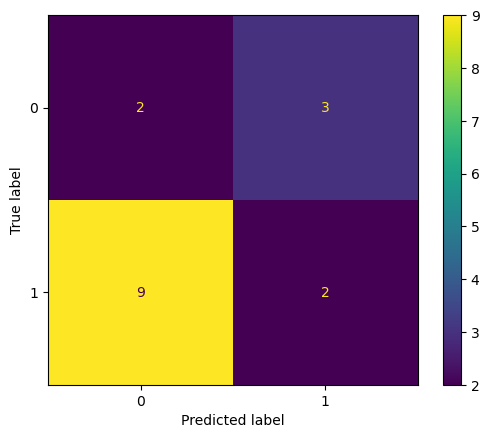

In [26]:
XTrain, XTest, yTrain, yTest = train_test_split(predictors,labels, random_state=3)

model = ensemble.RandomForestClassifier()

model.fit(XTrain,yTrain)

print(model.score(XTrain,yTrain))

print(model.score(XTest,yTest))

yPred = model.predict(XTest)

ConfusionMatrixDisplay(confusion_matrix(yTest, yPred), display_labels=model.classes_).plot()